## Goal

To produce datapoints in 7d space by building 7-spheres in all orthants (2 concentric spheres of radii, say, 1 and 2 in all orthants,
centered at say, a distance of 4 from all axes) in a non-uniform fashion, i.e., some orthants would have fewer points and some more points
(say, 25% of the orthants have fewer points, perhaps ~25 points in most orthants and ~4 points in the rarer orthants).

We wish to determine the performance of a neural network for different orthants - does it perform equally well or similar in all orthants,
determining that there is symmetry present in the data? Or does it fail to do so, doing well only in the orthants with more data? We use a
test set of say, 128 points per orthant to quantify each orthant's performance.

## Data

### Defining constants

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
LOW_COUNT = 4   # Average no. of points in a "rare" orthant
HIGH_COUNT = 25 # Average no. of points in a "typical" orthant
LOW_SPREAD = 2  # Allowed unidirectional deviation for no. of points in a "rare" orthant (i.e., 2 to 6 points)
HIGH_SPREAD = 8 # Allowed unidirectional deviation for no. of points in a "typical" orthant (i.e., 17 to 33 points)
VAL_COUNT = 4   # Validation data points per orthant
TEST_COUNT = 64 # Test data points per orthant, for final pattern
LOW_FRAC = 0.25 # Fraction of "rare" orthants
ZERO_FRAC = 0.25    # Fraction of empty orthants from rare orthants

In [73]:
CENTRE = 4 * torch.ones(7)
# The centre of the 7-spheres, without orthant-specificity, which can be included using ORTHANTS
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [6]:
LOW_RADIUS = 1. # Radius of the inner sphere (say, label 0) in each orthant
HIGH_RADIUS = 2.    # Radius of the outer sphere (say, label 1) in each orthant

### Data generation

Now, we describe a 7-sphere using the standard notation. <br>
Say, it is centered at $C = (C_1, C_2, ..., C_7)$ and has radius $r$. Each point can be described with the help of 6 angles, <br>
$\phi_1$, $\phi_2$, $\phi_3$, $\phi_4$, $\phi_5$, and $\phi_6$, where $\phi_6 \in [0, 2\pi)$ and $\phi_1, ..., \phi_5 \in [0, \pi]$ <br>
Any point $x = (x_1, x_2, ..., x_7)$ on the sphere can be described as follows: <br>
$x_1 = C_1 + r\cos(\phi_1)$ <br>
$x_2 = C_2 + r\sin(\phi_1)\cos(\phi_2)$ <br>
$x_3 = C_3 + r\sin(\phi_1)\sin(\phi_2)\cos(\phi_3)$ <br>
$x_4 = C_4 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\cos(\phi_4)$ <br>
$x_5 = C_5 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\cos(\phi_5)$ <br>
$x_6 = C_6 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\cos(\phi_6)$ <br>
$x_7 = C_7 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\sin(\phi_6)$
<br>

Hence, each datapoint will be sampled by randomly generating the 6 angles from appropriate uniform distributions and 
performing the mentioned transformation

#### Train data

In [17]:
from scripts.data.orthants import generate_train_data, generate_test_data, generate_flips

In [18]:
flips = generate_flips(0.2)

In [19]:
X_training, Y_training, orthant_counts = generate_train_data()
X_training.shape, Y_training.shape

(torch.Size([4835, 7]), torch.Size([4835, 1]))

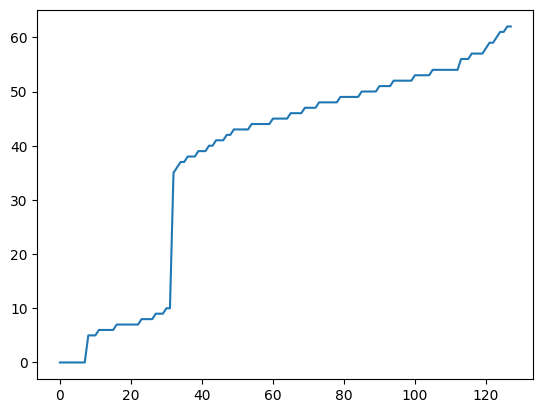

In [20]:
plt.plot(range(128), torch.sort(orthant_counts).values)

In [21]:
ZERO_ORTHANT_INDICES, LOW_ORTHANT_INDICES, HIGH_ORTHANT_INDICES = [], [], []
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDICES.append(i)
    elif orthant_counts[i] <= 10: # make it better!!
        LOW_ORTHANT_INDICES.append(i)
    else:
        HIGH_ORTHANT_INDICES.append(i)
len(ZERO_ORTHANT_INDICES), len(LOW_ORTHANT_INDICES), len(HIGH_ORTHANT_INDICES)

(8, 24, 96)

In [22]:
ZERO_ORTHANT_INDICES_FLIP, LOW_ORTHANT_INDICES_FLIP, HIGH_ORTHANT_INDICES_FLIP = [], [], []
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDICES_FLIP.append(i)
    elif orthant_counts[i] <= 10: # make it better!!
        LOW_ORTHANT_INDICES_FLIP.append(i)
    else:
        HIGH_ORTHANT_INDICES_FLIP.append(i)
len(ZERO_ORTHANT_INDICES_FLIP), len(LOW_ORTHANT_INDICES_FLIP), len(HIGH_ORTHANT_INDICES_FLIP)

(8, 24, 96)

In [23]:
X_training_flip, Y_training_flip, orthant_counts_flip = generate_train_data(flips=flips)
X_training_flip.shape, Y_training_flip.shape, flips.sum()

(torch.Size([4948, 7]),
 torch.Size([4948, 1]),
 tensor(23., dtype=torch.float64))

#### Train-Validation split

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([3868, 7]),
 torch.Size([967, 7]),
 torch.Size([3868, 1]),
 torch.Size([967, 1]))

In [25]:
X_train_flip, X_val_flip, Y_train_flip, Y_val_flip = train_test_split(X_training_flip, Y_training_flip, test_size=0.2)
X_train_flip.shape, X_val_flip.shape, Y_train_flip.shape, Y_val_flip.shape

(torch.Size([3958, 7]),
 torch.Size([990, 7]),
 torch.Size([3958, 1]),
 torch.Size([990, 1]))

#### Test data

In [28]:
X_test, Y_test = generate_test_data()
X_test.shape, Y_test.shape

(torch.Size([128, 128, 7]), torch.Size([128, 128, 1]))

In [29]:
X_test_flip, Y_test_flip = generate_test_data(flips=flips)
X_test_flip.shape, Y_test_flip.shape, flips.sum()

(torch.Size([128, 128, 7]),
 torch.Size([128, 128, 1]),
 tensor(23., dtype=torch.float64))

#### Data for hyperparameter tuning

In [30]:
from sklearn.utils import resample

X_train_cv, Y_train_cv = resample(X_train, Y_train, replace=False, n_samples=len(X_train)//5)
X_val_cv, Y_val_cv = resample(X_val, Y_val, replace=False, n_samples=len(X_val)//5)
X_train_cv.shape, X_val_cv.shape, Y_train_cv.shape, Y_val_cv.shape

(torch.Size([773, 7]),
 torch.Size([193, 7]),
 torch.Size([773, 1]),
 torch.Size([193, 1]))

In [31]:
X_train_flip_cv, Y_train_flip_cv = resample(X_train_flip, Y_train_flip, replace=False, n_samples=len(X_train_flip)//5)
X_val_flip_cv, Y_val_flip_cv = resample(X_val_flip, Y_val_flip, replace=False, n_samples=len(X_val_flip)//5)
X_train_flip_cv.shape, X_val_flip_cv.shape, Y_train_flip_cv.shape, Y_val_flip_cv.shape

(torch.Size([791, 7]),
 torch.Size([198, 7]),
 torch.Size([791, 1]),
 torch.Size([198, 1]))

## Neural network

In [32]:
device = 'cpu'

In [33]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(
        self,
        hidden_layers: int = 2,
        hidden_units: int = 32
    ) -> None:
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(in_features=7, out_features=hidden_units),
            nn.ReLU()
        )
        self.hidden = nn.Sequential()
        for i in range(hidden_layers):
            self.hidden.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            self.hidden.append(nn.ReLU())
        self.output = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.output(self.hidden(self.input(x)))


In [34]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32, shuffle=True)
train_cv_dataloader, val_cv_dataloader = make_dataloader(X_train_cv, Y_train_cv, batch_size=32, shuffle=True), make_dataloader(X_val_cv, Y_val_cv, batch_size=32, shuffle=True)
train_flip_dataloader, val_flip_dataloader = make_dataloader(X_train_flip, Y_train_flip, batch_size=32, shuffle=True), make_dataloader(X_val_flip, Y_val_flip, batch_size=32, shuffle=True)
train_flip_cv_dataloader, val_flip_cv_dataloader = make_dataloader(X_train_flip_cv, Y_train_flip_cv, batch_size=32, shuffle=True), make_dataloader(X_val_flip_cv, Y_val_flip_cv, batch_size=32, shuffle=True)

In [35]:
depths = [1, 2, 3, 4, 5]
widths = [16, 32, 64]
lambdas = [0, 1e-6, 1e-5, 1e-4]
etas = [1e-2, 1e-3, 1e-4]
betass = [(0.9, 0.999), (0.8, 0.9)]

### Without class flipping

In [36]:
best_depth = None
best_width = None
best_lambda = None
best_eta = None
best_betas = None
best_score = -1

In [37]:
from scripts.metrics import BinaryAccuracy
from scripts.train import train_model
from scripts.test import predict

count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 32
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_cv_dataloader,
                        val_dataloader=val_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_lambda = lambda_i
                        best_eta = eta
                        best_betas = betas

print(f'Results:\nDepth: {best_depth}\nWidth: {best_width}\nLambda: {best_lambda}\nEta: {best_eta}\nBetas: {best_betas}\nAccuracy after {EPOCHS} epochs: {best_score}')

/home/balakrishnan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Model 1 of 360 trained. Validation accuracy: 0.4508928656578064
Model 2 of 360 trained. Validation accuracy: 0.5089285969734192
Model 3 of 360 trained. Validation accuracy: 0.4866071343421936
Model 4 of 360 trained. Validation accuracy: 0.4196428656578064
Model 5 of 360 trained. Validation accuracy: 0.4464285671710968
Model 6 of 360 trained. Validation accuracy: 0.4553571343421936
Model 7 of 360 trained. Validation accuracy: 0.625
Model 8 of 360 trained. Validation accuracy: 0.6116071343421936
Model 9 of 360 trained. Validation accuracy: 0.59375
Model 10 of 360 trained. Validation accuracy: 0.4375
Model 11 of 360 trained. Validation accuracy: 0.6160714030265808
Model 12 of 360 trained. Validation accuracy: 0.5267857313156128
Model 13 of 360 trained. Validation accuracy: 0.5982142686843872
Model 14 of 360 trained. Validation accuracy: 0.46875
Model 15 of 360 trained. Validation accuracy: 0.59375
Model 16 of 360 trained. Validation accuracy: 0.6026785969734192
Model 17 of 360 trained. Va

In [38]:
best_model_nn = SimpleNN(hidden_layers=best_depth, hidden_units=best_width).to(device)

In [39]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, betas=best_betas, weight_decay=best_lambda)
metric = BinaryAccuracy()

In [40]:
from scripts.utils import EarlyStopping

early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [41]:
from scripts.train import train_model

history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.693642, Train score: 0.498229, Val loss: 0.692886, Val score: 0.513249
Epoch: 2 => Train loss: 0.692663, Train score: 0.517783, Val loss: 0.697859, Val score: 0.500288
Epoch: 3 => Train loss: 0.692996, Train score: 0.516861, Val loss: 0.694209, Val score: 0.500288
Epoch: 4 => Train loss: 0.691703, Train score: 0.529885, Val loss: 0.692485, Val score: 0.524050
Epoch: 5 => Train loss: 0.690911, Train score: 0.532800, Val loss: 0.696352, Val score: 0.503168
Epoch: 6 => Train loss: 0.690542, Train score: 0.532652, Val loss: 0.694658, Val score: 0.511953
Epoch: 7 => Train loss: 0.688697, Train score: 0.540880, Val loss: 0.697549, Val score: 0.492224
Epoch: 8 => Train loss: 0.688493, Train score: 0.549919, Val loss: 0.694699, Val score: 0.506336
Epoch: 9 => Train loss: 0.686761, Train score: 0.549661, Val loss: 0.701856, Val score: 0.520017
Epoch: 10 => Train loss: 0.685488, Train score: 0.559106, Val loss: 0.69

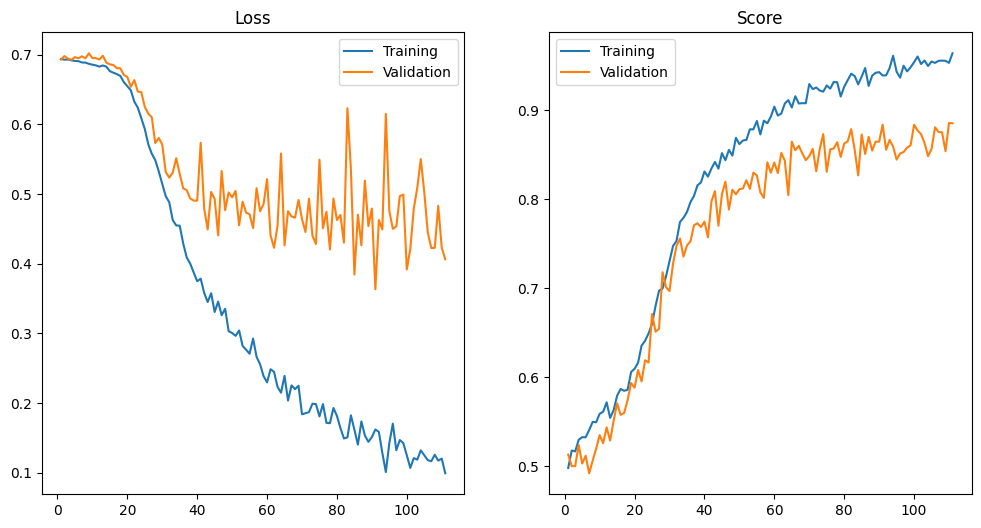

In [42]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [43]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

### With class flipping in random orthants

In [44]:
best_depth_flip = None
best_width_flip = None
best_lambda_flip = None
best_eta_flip = None
best_betas_flip = None
best_score_flip = -1

In [45]:
count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 32
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_flip_cv_dataloader,
                        val_dataloader=val_flip_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score_flip:
                        best_score_flip = score
                        best_depth_flip = depth
                        best_width_flip = width
                        best_lambda_flip = lambda_i
                        best_eta_flip = eta
                        best_betas_flip = betas

print(f'Results:\nDepth: {best_depth_flip}\nWidth: {best_width_flip}\nLambda: {best_lambda_flip}\nEta: {best_eta_flip}\nBetas: {best_betas_flip}\nAccuracy after {EPOCHS} epochs: {best_score_flip}')

Model 1 of 360 trained. Validation accuracy: 0.507440447807312
Model 2 of 360 trained. Validation accuracy: 0.5461309552192688
Model 3 of 360 trained. Validation accuracy: 0.4107142984867096
Model 4 of 360 trained. Validation accuracy: 0.4970238208770752
Model 5 of 360 trained. Validation accuracy: 0.4910714328289032
Model 6 of 360 trained. Validation accuracy: 0.5639880895614624
Model 7 of 360 trained. Validation accuracy: 0.5133928656578064
Model 8 of 360 trained. Validation accuracy: 0.5163690447807312
Model 9 of 360 trained. Validation accuracy: 0.4672618806362152
Model 10 of 360 trained. Validation accuracy: 0.4479166865348816
Model 11 of 360 trained. Validation accuracy: 0.5327380895614624
Model 12 of 360 trained. Validation accuracy: 0.4538690447807312
Model 13 of 360 trained. Validation accuracy: 0.5208333134651184
Model 14 of 360 trained. Validation accuracy: 0.5372024178504944
Model 15 of 360 trained. Validation accuracy: 0.443452388048172
Model 16 of 360 trained. Validation 

In [46]:
best_model_flip_nn = SimpleNN(hidden_layers=best_depth_flip, hidden_units=best_width_flip).to(device)

In [47]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_flip_nn.parameters(), lr=best_eta_flip, betas=best_betas_flip, weight_decay=best_lambda_flip)
metric = BinaryAccuracy()

In [48]:
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [49]:
history = train_model(
    model=best_model_flip_nn,
    train_dataloader=train_flip_dataloader,
    val_dataloader=val_flip_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.696346, Train score: 0.497594, Val loss: 0.693087, Val score: 0.504368
Epoch: 2 => Train loss: 0.694187, Train score: 0.493310, Val loss: 0.695037, Val score: 0.482930
Epoch: 3 => Train loss: 0.694573, Train score: 0.502177, Val loss: 0.693161, Val score: 0.488844
Epoch: 4 => Train loss: 0.693308, Train score: 0.500641, Val loss: 0.693111, Val score: 0.504234
Epoch: 5 => Train loss: 0.693086, Train score: 0.498832, Val loss: 0.693462, Val score: 0.503965
Epoch: 6 => Train loss: 0.693482, Train score: 0.503666, Val loss: 0.693436, Val score: 0.503831
Epoch: 7 => Train loss: 0.693398, Train score: 0.501260, Val loss: 0.693407, Val score: 0.503898
Epoch: 8 => Train loss: 0.693431, Train score: 0.501879, Val loss: 0.693295, Val score: 0.504099
Epoch: 9 => Train loss: 0.693148, Train score: 0.508317, Val loss: 0.693346, Val score: 0.495968
Epoch: 10 => Train loss: 0.693428, Train score: 0.483229, Val loss: 0.69

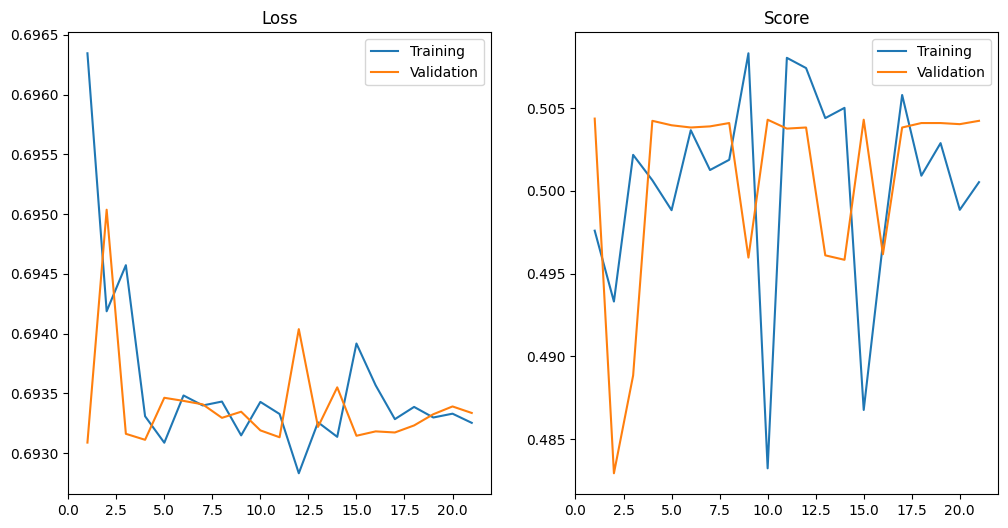

In [50]:
plot_train_history(history)

In [51]:
scores_flip_nn = torch.tensor([
    metric(
        predict(best_model_flip_nn, X_test_flip[i], device),
        Y_test_flip[i]
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, NN')

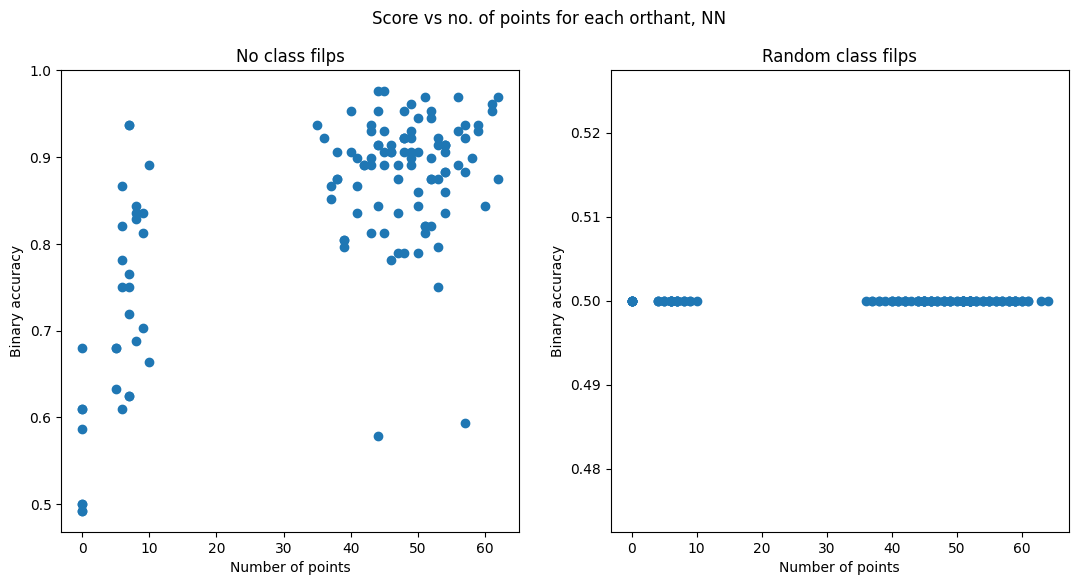

In [52]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('No class filps')

plt.subplot(122)
plt.scatter(orthant_counts_flip, scores_flip_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('Random class filps')

plt.suptitle('Score vs no. of points for each orthant, NN')

In [53]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_nn).statistic, pearsonr(orthant_counts_flip, scores_flip_nn).statistic

/home/balakrishnan/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


(0.6745242744236596, nan)

In [54]:
scores_nn.mean(), scores_flip_nn.mean()

(tensor(0.8407), tensor(0.5000))

In [55]:
print('Performance in empty orthants: ', scores_nn[ZERO_ORTHANT_INDICES].mean(), scores_flip_nn[ZERO_ORTHANT_INDICES_FLIP].mean())
print('Performance in rare orthants: ', scores_nn[LOW_ORTHANT_INDICES].mean(), scores_flip_nn[LOW_ORTHANT_INDICES_FLIP].mean())
print('Performance in typical orthants: ', scores_nn[HIGH_ORTHANT_INDICES].mean(), scores_flip_nn[HIGH_ORTHANT_INDICES_FLIP].mean())

Performance in empty orthants:  tensor(0.5586) tensor(0.5000)
Performance in rare orthants:  tensor(0.7617) tensor(0.5000)
Performance in typical orthants:  tensor(0.8840) tensor(0.5000)


Okay, maybe a neural network can find symmetry? Can an SVM do this too? Is the test data too similar to training?

## SVM

In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [57]:
ntk = NTK(best_model_nn).get_ntk

In [58]:
model_base = SVC(kernel=ntk)
params = {
    'C': np.logspace(-5, 5, 11)
}
scorer = make_scorer(accuracy_score)

### Without class flipping

In [59]:
model_cv = GridSearchCV(
    estimator=model_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv.fit(X_train_cv, Y_train_cv.squeeze())
best_params = model_cv.best_params_
best_params

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/home/balakrishnan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/balakrishnan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/balakrishnan/.local/lib/python3.10/site-packages/t

[CV 4/5] END ...........................C=1e-05;, score=0.506 total time=   1.8s
[CV 3/5] END ...........................C=1e-05;, score=0.510 total time=   1.9s
[CV 1/5] END ...........................C=1e-05;, score=0.503 total time=   2.0s
[CV 2/5] END ...........................C=1e-05;, score=0.503 total time=   2.0s
[CV 5/5] END ...........................C=1e-05;, score=0.506 total time=   2.0s
[CV 1/5] END ..........................C=0.0001;, score=0.510 total time=   1.9s
[CV 2/5] END ..........................C=0.0001;, score=0.516 total time=   1.9s
[CV 3/5] END ..........................C=0.0001;, score=0.510 total time=   1.9s
[CV 4/5] END ..........................C=0.0001;, score=0.506 total time=   2.0s
[CV 5/5] END ..........................C=0.0001;, score=0.506 total time=   2.0s
[CV 1/5] END ...........................C=0.001;, score=0.555 total time=   1.8s
[CV 2/5] END ...........................C=0.001;, score=0.555 total time=   1.9s
[CV 4/5] END ...............

{'C': 100000.0}

In [60]:
best_model_km = SVC(C=best_params['C'], kernel=ntk)

In [61]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(C=100000.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7fe2bfa2c3d0>>)

In [62]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.9953464322647363, 0.8231644260599793)

In [63]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

### With class flipping in random orthants

In [64]:
model_cv = GridSearchCV(
    estimator=model_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv.fit(X_train_flip_cv, Y_train_flip_cv.squeeze())
best_params_flip = model_cv.best_params_
best_params_flip

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/home/balakrishnan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/balakrishnan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/balakrishnan/.local/lib/python3.10/site-packages/t

[CV 2/5] END ...........................C=1e-05;, score=0.519 total time=   2.0s
[CV 3/5] END ...........................C=1e-05;, score=0.519 total time=   2.0s
[CV 4/5] END ...........................C=1e-05;, score=0.525 total time=   2.1s
[CV 5/5] END ...........................C=1e-05;, score=0.525 total time=   2.0s
[CV 1/5] END ...........................C=1e-05;, score=0.522 total time=   2.1s
[CV 1/5] END ..........................C=0.0001;, score=0.522 total time=   2.0s
[CV 2/5] END ..........................C=0.0001;, score=0.519 total time=   2.0s
[CV 4/5] END ..........................C=0.0001;, score=0.525 total time=   2.0s
[CV 5/5] END ..........................C=0.0001;, score=0.519 total time=   2.0s
[CV 3/5] END ..........................C=0.0001;, score=0.519 total time=   2.0s
[CV 1/5] END ...........................C=0.001;, score=0.535 total time=   1.9s
[CV 4/5] END ...........................C=0.001;, score=0.544 total time=   2.0s
[CV 2/5] END ...............

{'C': 1000.0}

In [65]:
best_model_flip_km = SVC(C=best_params_flip['C'], kernel=ntk)

In [66]:
best_model_flip_km.fit(X_train_flip, Y_train_flip.squeeze())

SVC(C=1000.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7fe2bfa2c3d0>>)

In [67]:
preds_train, preds_val = best_model_flip_km.predict(X_train_flip), best_model_flip_km.predict(X_val_flip)
score_train, score_val = accuracy_score(Y_train_flip.squeeze(), preds_train), accuracy_score(Y_val_flip.squeeze(), preds_val)
score_train, score_val

(0.9186457806973218, 0.7505050505050505)

In [68]:
scores_flip_km = np.array([
    accuracy_score(
        best_model_flip_km.predict(X_test_flip[i]),
        Y_test_flip[i].squeeze()
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, SVM')

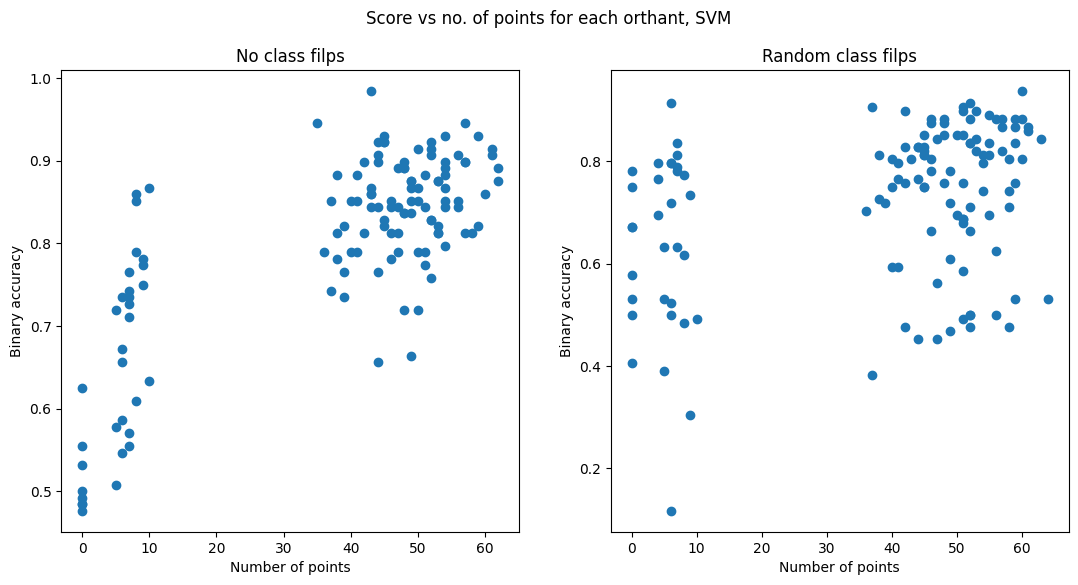

In [69]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('No class filps')

plt.subplot(122)
plt.scatter(orthant_counts_flip, scores_flip_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('Random class filps')

plt.suptitle('Score vs no. of points for each orthant, SVM')

In [70]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_km).statistic, pearsonr(orthant_counts_flip, scores_flip_km).statistic

(0.759717518568916, 0.33552740454559093)

In [71]:
scores_km.mean(), scores_flip_km.mean()

(0.7989501953125, 0.72216796875)

In [72]:
print('Performance in empty orthants: ', scores_km[ZERO_ORTHANT_INDICES].mean(), scores_flip_km[ZERO_ORTHANT_INDICES_FLIP].mean())
print('Performance in rare orthants: ', scores_km[LOW_ORTHANT_INDICES].mean(), scores_flip_km[LOW_ORTHANT_INDICES_FLIP].mean())
print('Performance in typical orthants: ', scores_km[HIGH_ORTHANT_INDICES].mean(), scores_flip_km[HIGH_ORTHANT_INDICES_FLIP].mean())

Performance in empty orthants:  0.5185546875 0.6953125
Performance in rare orthants:  0.6966145833333334 0.7106119791666666
Performance in typical orthants:  0.847900390625 0.727294921875
